In [1]:
import numpy as np
import pandas as pd
import biogeme
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Constrained GBM

In [2]:
london_data = pd.read_csv("Data/dataset_london.csv")

ld_with_one_trip = ld_with_car.groupby(by=['household_id']).sample(1)

In [3]:
london_data = pd.read_csv("Data/dataset_london.csv")

ld_with_one_trip = ld_with_car.groupby(by=['household_id']).sample(1)

Feature = ld_with_one_trip[['travel_mode', 'survey_year', 'dur_walking', 'dur_cycling', 'dur_pt_total', 'dur_driving', 'cost_transit', 'cost_driving_total']]

X = Feature[['survey_year', 'dur_walking', 'dur_cycling', 'dur_pt_total', 'dur_driving', 'cost_transit', 'cost_driving_total']]
y = Feature[['travel_mode', 'survey_year']]

new_mode = {'walk':1, 'cycle':1, 'pt':1, 'drive':0}

y = y.replace({'travel_mode': new_mode})

X['dur_non_driving'] = X[[ 'dur_walking', 'dur_cycling', 'dur_pt_total']].min(axis=1)

X_train = X[X['survey_year']<3]
X_validate =  X[X['survey_year']==3]
y_train = y[y['survey_year']<3]
y_validate = y[y['survey_year']==3]

X_train = X_train.drop(columns=['survey_year', 'dur_walking', 'dur_cycling', 'dur_pt_total'])
X_validate = X_validate.drop(columns=['survey_year', 'dur_walking', 'dur_cycling', 'dur_pt_total'])
y_train = y_train.drop(columns=['survey_year'])
y_validate = y_validate.drop(columns=['survey_year'])

#X_train = X_train.drop(columns=['survey_year', 'dur_walking', 'dur_cycling', 'dur_pt_total', 'cost_transit', 'cost_driving_total'])
#X_validate = X_validate.drop(columns=['survey_year', 'dur_walking', 'dur_cycling', 'dur_pt_total', 'cost_transit', 'cost_driving_total'])
#y_train = y_train.drop(columns=['survey_year'])
#y_validate = y_validate.drop(columns=['survey_year'])

In [5]:
dtrain = xgb.DMatrix(X_train, label=y_train)
deval = xgb.DMatrix(X_validate, label=y_validate)

evallist = [(dtrain, 'train'), (deval, 'eval')]

num_round = 100

param = {'max_depth': 1, 
         'objective': 'binary:logistic', 
         'lambda':0, 
         'alpha':0, 
         'monotone_constraints': (-1, -1, -1, -1), 
         'interaction_constraints': [['dur_driving'], ['cost_transit'], ['cost_driving_total'], ['dur_non_driving']]}


#param = {'max_depth': 1, 
#         'objective': 'binary:logistic', 
#         'lambda':0, 
#         'alpha':0, 
#         'monotone_constraints': (-1, -1), 
#         'interaction_constraints': [['dur_driving'], ['dur_non_driving']]}

In [6]:
xgb_constrained = xgb.train(param, dtrain, num_round, evallist)

In [7]:
dtest = xgb.DMatrix(X_validate)

y_pred=np.rint(xgb_constrained.predict(dtest))
xgb_constrained.get_params()

# Unconstrained model

In [8]:
num_round = 100

param_unc = {'max_depth': 1, 
         'objective': 'binary:logistic', 
         'lambda':0, 
         'alpha':0}

In [9]:
xgb_unconstrained = xgb.train(param_unc, dtrain, num_round, evallist)

In [10]:
dtest = xgb.DMatrix(X_validate)

y_pred_unc=np.rint(xgb_unconstrained.predict(dtest))

accuracy_score(y_validate, y_pred_unc)

# RUM

In [15]:
# Translated to .py by Yundi Zhang
# Jan 2017
# Adapted to PandasBiogeme by Michel Bierlaire
# Sun Oct 21 23:00:22 2018

import pandas as pd
import biogeme.database as db
import biogeme.biogeme as bio
from biogeme.expressions import Beta, DefineVariable
from biogeme.models import loglogit
import biogeme.models as models
import biogeme.messaging as msg

#pandas = pd.read_csv("Data/data_for_biogeme_london.csv")
#database = db.Database("netherlands",pandas)
#df_train = pandas[pandas['survey_year']<3]
#df_test = pandas[pandas['survey_year']==3]

database = X.copy().reset_index(drop=True)
choice = y.copy().reset_index(drop=True)
choice = choice.rename(columns={'travel_mode':'choice'})
data_for_biogeme = database.merge(choice)

df_train = data_for_biogeme[data_for_biogeme['survey_year']<3]
df_test = data_for_biogeme[data_for_biogeme['survey_year']==3]

database_train = db.Database("london_train", df_train)
database_test = db.Database("london_test", df_test)
pd.options.display.float_format = '{:.3g}'.format

globals().update(database_train.variables)

#exclude = sp != 0
#database.remove(exclude)
#database_train.remove(exclude)
#database_test.remove(exclude)

# Parameters to be estimated
# Arguments:
#   1  Name for report. Typically, the same as the variable
#   2  Starting value
#   3  Lower bound
#   4  Upper bound
#   5  0: estimate the parameter, 1: keep it fixed
ASC_CAR	       = Beta('ASC_CAR',0,None,None,0)
ASC_NC	   = Beta('ASC_NC',0,None,None,1)
BETA_COST_CAR  = Beta('BETA_COST_CAR',0,None,None,0)
BETA_COST_NC = Beta('BETA_COST_NC',0,None,None,0)
BETA_TT_CAR    = Beta('BETA_TT_CAR',0,None,None,0)
BETA_TT_NC   = Beta('BETA_TT_NC',0,None,None,0)
#BETA_TT_CAR	 = Beta('BETA_TT_CAR',0,None,None,0)
#BETA_TT_RAIL = Beta('BETA_TT_RAIL',0,None,None,0)

# Define here arithmetic expressions for name that are not directly available from the data
#rail_time  = DefineVariable('rail_time',(  rail_ivtt   +  rail_acc_time   ) +  rail_egr_time  ,database_train)
#car_time  = DefineVariable('car_time', car_ivtt   +  car_walk_time  ,database_train)
#rate_G2E = DefineVariable('rate_G2E', 0.44378022,database_train)
#car_cost_euro = DefineVariable('car_cost_euro', car_cost * rate_G2E,database_train)
#rail_cost_euro = DefineVariable('rail_cost_euro', rail_cost * rate_G2E,database_train)

#rail_time  = DefineVariable('rail_time',(  rail_ivtt   +  rail_acc_time   ) +  rail_egr_time  ,database_test)
#car_time  = DefineVariable('car_time', car_ivtt   +  car_walk_time  ,database_test)
#rate_G2E = DefineVariable('rate_G2E', 0.44378022,database_test)
#car_cost_euro = DefineVariable('car_cost_euro', car_cost * rate_G2E,database_test)
#rail_cost_euro = DefineVariable('rail_cost_euro', rail_cost * rate_G2E,database_test)

# Utilities
__Car = ASC_CAR  + BETA_COST_CAR * cost_driving_total + BETA_TT_CAR * dur_driving
__Rail = ASC_NC + BETA_COST_NC * cost_transit + BETA_TT_NC * dur_non_driving
__V = {0: __Car,1: __Rail}
__av = {0: 1,1: 1}

#__Car = ASC_CAR  + BETA_TT_CAR * dur_driving
#__Rail = ASC_NC + BETA_TT_NC * dur_non_driving
#__V = {0: __Car,1: __Rail}
#__av = {0: 1,1: 1}

# The choice model is a logit, with availability conditions
logprob = loglogit(__V,__av,choice)
biogeme  = bio.BIOGEME(database_train,logprob)
biogeme.modelName = "binary_london"
biogeme.generateHtml = False
biogeme.generatePickle = False

results = biogeme.estimate()

#define level of verbosity
logger = msg.bioMessage()
logger.setDetailed()

# Get the results in a pandas table
pandasResults = results.getEstimatedParameters()
print(pandasResults)
print(f"Nbr of observations: {database_train.getNumberOfObservations()}")
print(f"LL(0) =    {results.data.initLogLike:.3f}")
print(f"LL(beta) = {results.data.logLike:.3f}")
print(f"rho bar square = {results.data.rhoBarSquare:.3g}")
print(f"Output file: {results.data.htmlFileName}")

In [16]:
pandasResults.to_csv('Data/binary_london_results.csv')

In [17]:
globals().update(database_test.variables)

prob_car = models.logit(__V, __av, 0)
prob_nc = models.logit(__V, __av, 1)

simulate ={'Prob. car': prob_car,
           'Prob. NC':  prob_nc}

biogeme = bio.BIOGEME(database_test, simulate)
biogeme.modelName = "london_logit_test"

betas = biogeme.freeBetaNames

betaValues = results.getBetaValues()

simulatedValues = biogeme.simulate(betaValues)

prob_max = simulatedValues.idxmax(axis=1)
prob_max = prob_max.replace({'Prob. car': 0, 'Prob. NC': 1})

data = {'y_Actual':    df_test['choice'],
        'y_Predicted': prob_max
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

print(confusion_matrix)

accuracy = np.diagonal(confusion_matrix.to_numpy()).sum()/confusion_matrix.to_numpy().sum()
print('Global accuracy of the model:', accuracy)

In [11]:
pandasResults = pd.read_csv('Data/binary_london_results.csv', index_col=0)

In [18]:
BETA_COST_CAR = pandasResults.loc['BETA_COST_CAR', 'Value']
BETA_COST_NC = pandasResults.loc['BETA_COST_NC', 'Value']
BETA_TT_CAR = pandasResults.loc['BETA_TT_CAR', 'Value']
BETA_TT_NC = pandasResults.loc['BETA_TT_NC', 'Value']

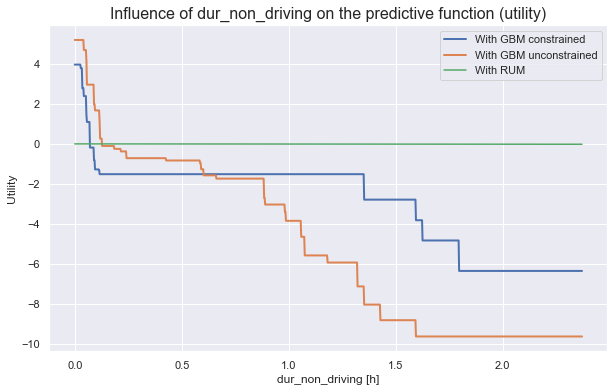

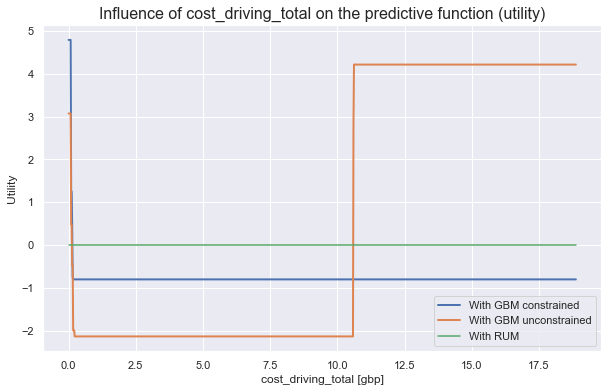

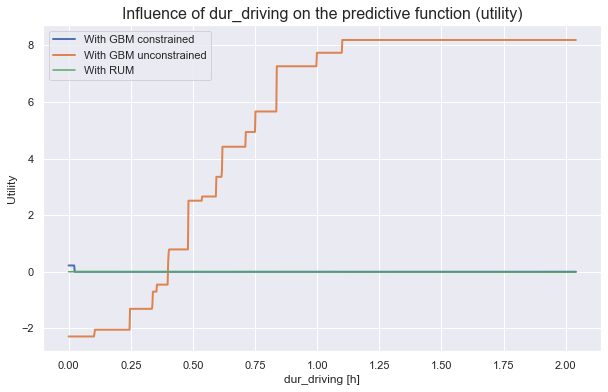

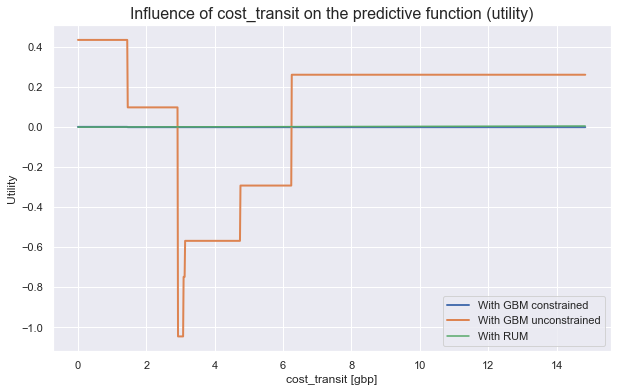

In [19]:
from NonlinearUtilityFunction import plotHisto

plotHisto(xgb_constrained, X, ['h', 'gbp', 'h',  'gbp'], Betas = [BETA_TT_NC, BETA_COST_CAR, BETA_TT_CAR, BETA_COST_NC ], model_unconstrained =xgb_unconstrained)

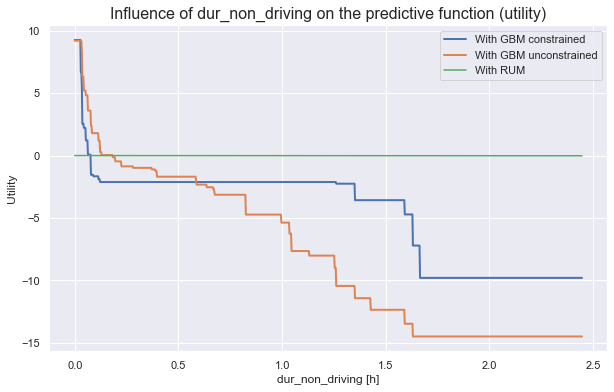

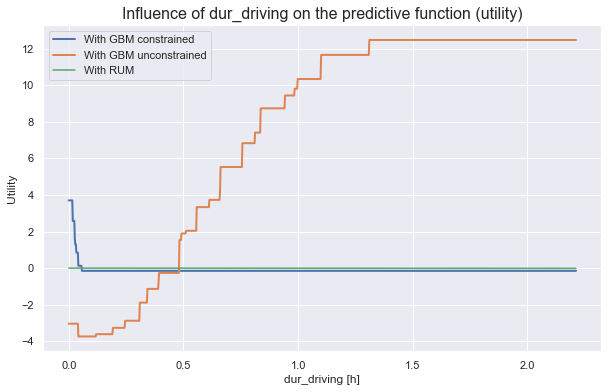

In [32]:
plotHisto(xgb_constrained, X, ['h', 'h'], Betas = [BETA_TT_CAR, BETA_TT_NC], model_unconstrained =xgb_unconstrained)